In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

In [2]:
# load data
digits = load_digits()
X = digits.data
y = digits.target
y = LabelBinarizer().fit_transform(y)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.2)

In [3]:
def add_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 

    # here to dropout
    Wx_plus_b = tf.nn.dropout(Wx_plus_b , keep_prob)
  
    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)
        
    return outputs


def highway_layer(inputs , in_size , out_size , activaction_function = None):
    with tf.variable_scope('transform'): 
        # weights and biases for transform
        Weights_t = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight_t')
        biases_t = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_t')
        
        # fully connected product for transform
        transform_output_temp = tf.add(tf.matmul(inputs , Weights_t) , biases_t , name = 'transform_gate') 
        transform_output_temp = tf.nn.dropout(transform_output_temp , keep_prob)
        
        if activaction_function is None:
            transform_output = activaction_function(transform_output_temp)
        else:
            transform_output = transform_output_temp

    with tf.variable_scope('copy'):  
        # weights and biases for copy
        Weights_c = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.001) , name = 'weight_c')
        biases_c = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias_c')

        # fully connected product for copy 
        # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
        copy_coef = tf.nn.sigmoid(tf.add(tf.matmul(inputs , Weights_c) , biases_c) , name = 'copy_gate') 
    
    with tf.variable_scope('output'):
        final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)
               
    return final_output


def output_layer(inputs , in_size , out_size , activaction_function = None):
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001))
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001)
    Wx_plus_b = tf.matmul(inputs , Weights) + biases
 
    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b)

    return outputs

In [4]:
# define placeholder for inputs to network
keep_prob = tf.placeholder(tf.float32)
xs = tf.placeholder(tf.float32 , [None , 64])
ys = tf.placeholder(tf.float32 , [None , 10])

In [5]:
layer_list = []

# add hidden layer
with tf.variable_scope('input_layer'):
    input_layer = add_layer(xs , 64 , 20 , activaction_function = tf.nn.relu)
layer_list.append(input_layer)

# build hidden layers & highway layers
with tf.variable_scope('hidden_layer'):
    for l_n in range(0 , 30):
        hidden_layer = highway_layer(layer_list[l_n] , layer_list[l_n].shape[1].value , 20 , activaction_function = tf.nn.relu)
        layer_list.append(hidden_layer)

# build output layer
with tf.variable_scope('output_layer'):  
    prediction = output_layer(layer_list[-1] , layer_list[-1].shape[1].value , 10 , activaction_function = tf.nn.softmax)

In [6]:
# the error between prediction and real data
cross_entropy_temp = -tf.reduce_sum(ys * tf.log(prediction + 1e-9) , 1)
cross_entropy = tf.reduce_mean(cross_entropy_temp)
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

correct = tf.equal(tf.argmax(prediction , axis = 1) , tf.argmax(ys , axis = 1)) 
correct = tf.cast(correct , dtype = tf.float32)
accuracy = tf.reduce_mean(correct)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# minibatch data index
epochs = 2000
num = 100
step = (math.ceil(len(X_train) / num)) * num
temp = []
j = 0
index = []
for ii in range(0 , step):
    j = j + 1
    if j > len(X_train):
        j = j - (len(X_train))   
    temp.append(j)  
    if len(temp) == num:
        index.append(temp)
        temp = []
index = list(np.array(index) - 1)

def shuffle_function():
    shuffle_indices = np.random.permutation(np.arange(len(X_train)))
    X_train_shuffle , y_train_shuffle = X_train[shuffle_indices] , y_train[shuffle_indices]
    return [np.array(X_train_shuffle) , np.array(y_train_shuffle)]

shuffle_data = shuffle_function()
X_data , y_data = shuffle_data[0] , shuffle_data[1]
    
train_loss_his , train_acc_his = [] , []
val_loss_his , val_acc_his = [] , []
for epoch_i in range(0 , epochs):        
    for batch_i in range(0 , len(index)):        
        sess.run(train_step , feed_dict = {xs : X_data[index[batch_i] , :] , 
                                           ys : y_data[index[batch_i] , :] , 
                                           keep_prob : 0.8})

    train_loss , train_acc = sess.run([cross_entropy , accuracy] ,
                                      feed_dict = {xs : X_data[index[batch_i] , :] , 
                                                   ys : y_data[index[batch_i] , :] , 
                                                   keep_prob : 1})
    train_loss_his.append(train_loss)
    train_acc_his.append(train_acc)
    
    val_loss , val_acc = sess.run([cross_entropy , accuracy] , feed_dict = {xs: X_val , ys : y_val , keep_prob : 1}) 
    val_loss_his.append(val_loss)
    val_acc_his.append(val_acc)
    
    print('epoch : {} \ntrain_loss : {:.2f} \ntrain_accuracy : {:.2%} \nvalidation_loss : {:.2f} \nvalidation_accuracy : {:.2%}\n'.\
          format(epoch_i , train_loss , train_acc , val_loss , val_acc))

epoch : 0 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 1 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 2 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 3 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 4 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 5 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 6 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 7 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.30 
validation_accuracy : 7.64%

epoch : 8 
train_loss : 2.30 
train_accuracy : 12.00% 
validation_loss : 2.31 
validation_accuracy : 7.64%

epoch : 9 
train_loss : 2.30

epoch : 76 
train_loss : 0.38 
train_accuracy : 87.00% 
validation_loss : 0.56 
validation_accuracy : 80.21%

epoch : 77 
train_loss : 0.35 
train_accuracy : 82.00% 
validation_loss : 0.62 
validation_accuracy : 81.94%

epoch : 78 
train_loss : 0.36 
train_accuracy : 81.00% 
validation_loss : 0.59 
validation_accuracy : 81.94%

epoch : 79 
train_loss : 0.31 
train_accuracy : 92.00% 
validation_loss : 0.57 
validation_accuracy : 81.94%

epoch : 80 
train_loss : 0.32 
train_accuracy : 90.00% 
validation_loss : 0.54 
validation_accuracy : 81.94%

epoch : 81 
train_loss : 0.30 
train_accuracy : 81.00% 
validation_loss : 0.57 
validation_accuracy : 81.25%

epoch : 82 
train_loss : 0.30 
train_accuracy : 86.00% 
validation_loss : 0.55 
validation_accuracy : 81.60%

epoch : 83 
train_loss : 0.27 
train_accuracy : 82.00% 
validation_loss : 0.54 
validation_accuracy : 82.64%

epoch : 84 
train_loss : 0.27 
train_accuracy : 86.00% 
validation_loss : 0.54 
validation_accuracy : 81.60%

epoch : 85

epoch : 151 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.38 
validation_accuracy : 92.01%

epoch : 152 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.43 
validation_accuracy : 90.97%

epoch : 153 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.38 
validation_accuracy : 90.97%

epoch : 154 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.41 
validation_accuracy : 91.32%

epoch : 155 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.49 
validation_accuracy : 92.01%

epoch : 156 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.46 
validation_accuracy : 92.36%

epoch : 157 
train_loss : 0.13 
train_accuracy : 97.00% 
validation_loss : 0.27 
validation_accuracy : 91.32%

epoch : 158 
train_loss : 0.11 
train_accuracy : 98.00% 
validation_loss : 0.27 
validation_accuracy : 92.36%

epoch : 159 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.29 
validation_accuracy : 91.32%

e

epoch : 225 
train_loss : 0.08 
train_accuracy : 99.00% 
validation_loss : 0.28 
validation_accuracy : 94.10%

epoch : 226 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.26 
validation_accuracy : 92.71%

epoch : 227 
train_loss : 0.09 
train_accuracy : 98.00% 
validation_loss : 0.35 
validation_accuracy : 92.01%

epoch : 228 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 94.44%

epoch : 229 
train_loss : 0.09 
train_accuracy : 98.00% 
validation_loss : 0.26 
validation_accuracy : 93.40%

epoch : 230 
train_loss : 0.11 
train_accuracy : 96.00% 
validation_loss : 0.30 
validation_accuracy : 92.01%

epoch : 231 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.29 
validation_accuracy : 91.32%

epoch : 232 
train_loss : 0.09 
train_accuracy : 98.00% 
validation_loss : 0.36 
validation_accuracy : 89.93%

epoch : 233 
train_loss : 0.09 
train_accuracy : 97.00% 
validation_loss : 0.29 
validation_accuracy : 90.97%

e

epoch : 299 
train_loss : 0.05 
train_accuracy : 100.00% 
validation_loss : 0.27 
validation_accuracy : 92.36%

epoch : 300 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.28 
validation_accuracy : 92.01%

epoch : 301 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.38 
validation_accuracy : 92.36%

epoch : 302 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.40 
validation_accuracy : 93.06%

epoch : 303 
train_loss : 0.28 
train_accuracy : 95.00% 
validation_loss : 0.48 
validation_accuracy : 90.62%

epoch : 304 
train_loss : 0.11 
train_accuracy : 98.00% 
validation_loss : 0.39 
validation_accuracy : 92.01%

epoch : 305 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.34 
validation_accuracy : 92.71%

epoch : 306 
train_loss : 0.05 
train_accuracy : 100.00% 
validation_loss : 0.36 
validation_accuracy : 91.32%

epoch : 307 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.37 
validation_accuracy : 92.0

epoch : 373 
train_loss : 0.05 
train_accuracy : 100.00% 
validation_loss : 0.36 
validation_accuracy : 91.32%

epoch : 374 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.36 
validation_accuracy : 91.32%

epoch : 375 
train_loss : 0.12 
train_accuracy : 93.00% 
validation_loss : 0.38 
validation_accuracy : 89.93%

epoch : 376 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.35 
validation_accuracy : 92.01%

epoch : 377 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.39 
validation_accuracy : 91.67%

epoch : 378 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.38 
validation_accuracy : 90.97%

epoch : 379 
train_loss : 0.22 
train_accuracy : 95.00% 
validation_loss : 0.41 
validation_accuracy : 89.58%

epoch : 380 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.32 
validation_accuracy : 93.40%

epoch : 381 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.40 
validation_accuracy : 91.67%

epoch : 448 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.33 
validation_accuracy : 91.67%

epoch : 449 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.30 
validation_accuracy : 92.71%

epoch : 450 
train_loss : 0.02 
train_accuracy : 99.00% 
validation_loss : 0.34 
validation_accuracy : 92.36%

epoch : 451 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.37 
validation_accuracy : 92.36%

epoch : 452 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.36 
validation_accuracy : 92.01%

epoch : 453 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.33 
validation_accuracy : 92.36%

epoch : 454 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.34 
validation_accuracy : 93.06%

epoch : 455 
train_loss : 0.05 
train_accuracy : 98.00% 
validation_loss : 0.33 
validation_accuracy : 93.40%

epoch : 456 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.42 
validation_accuracy : 93.06%

e

epoch : 522 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.41 
validation_accuracy : 93.06%

epoch : 523 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.41 
validation_accuracy : 93.75%

epoch : 524 
train_loss : 0.01 
train_accuracy : 100.00% 
validation_loss : 0.36 
validation_accuracy : 94.79%

epoch : 525 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.37 
validation_accuracy : 94.10%

epoch : 526 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.36 
validation_accuracy : 93.40%

epoch : 527 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.33 
validation_accuracy : 93.40%

epoch : 528 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.33 
validation_accuracy : 92.71%

epoch : 529 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.45 
validation_accuracy : 92.71%

epoch : 530 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.42 
validation_accuracy : 92

epoch : 597 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.23 
validation_accuracy : 92.71%

epoch : 598 
train_loss : 0.11 
train_accuracy : 97.00% 
validation_loss : 0.27 
validation_accuracy : 91.67%

epoch : 599 
train_loss : 0.12 
train_accuracy : 97.00% 
validation_loss : 0.30 
validation_accuracy : 89.24%

epoch : 600 
train_loss : 0.15 
train_accuracy : 96.00% 
validation_loss : 0.32 
validation_accuracy : 89.58%

epoch : 601 
train_loss : 0.14 
train_accuracy : 96.00% 
validation_loss : 0.31 
validation_accuracy : 89.24%

epoch : 602 
train_loss : 0.10 
train_accuracy : 98.00% 
validation_loss : 0.27 
validation_accuracy : 90.97%

epoch : 603 
train_loss : 0.16 
train_accuracy : 97.00% 
validation_loss : 0.28 
validation_accuracy : 89.24%

epoch : 604 
train_loss : 0.10 
train_accuracy : 98.00% 
validation_loss : 0.28 
validation_accuracy : 89.58%

epoch : 605 
train_loss : 0.09 
train_accuracy : 99.00% 
validation_loss : 0.26 
validation_accuracy : 90.62%

e

epoch : 672 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.28 
validation_accuracy : 92.36%

epoch : 673 
train_loss : 0.05 
train_accuracy : 98.00% 
validation_loss : 0.28 
validation_accuracy : 93.06%

epoch : 674 
train_loss : 0.04 
train_accuracy : 98.00% 
validation_loss : 0.31 
validation_accuracy : 92.71%

epoch : 675 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.33 
validation_accuracy : 93.40%

epoch : 676 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.33 
validation_accuracy : 93.40%

epoch : 677 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.32 
validation_accuracy : 93.06%

epoch : 678 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.33 
validation_accuracy : 91.67%

epoch : 679 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.33 
validation_accuracy : 92.01%

epoch : 680 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.34 
validation_accuracy : 92.36%

epoch : 747 
train_loss : 0.09 
train_accuracy : 99.00% 
validation_loss : 0.40 
validation_accuracy : 91.67%

epoch : 748 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.39 
validation_accuracy : 91.67%

epoch : 749 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.37 
validation_accuracy : 91.67%

epoch : 750 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.35 
validation_accuracy : 91.32%

epoch : 751 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.39 
validation_accuracy : 90.97%

epoch : 752 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.41 
validation_accuracy : 90.97%

epoch : 753 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.40 
validation_accuracy : 91.32%

epoch : 754 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.39 
validation_accuracy : 90.62%

epoch : 755 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.41 
validation_accuracy : 90.62%

e

epoch : 821 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.25 
validation_accuracy : 94.10%

epoch : 822 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.26 
validation_accuracy : 93.40%

epoch : 823 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.23 
validation_accuracy : 93.06%

epoch : 824 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy : 92.01%

epoch : 825 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.26 
validation_accuracy : 91.32%

epoch : 826 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.26 
validation_accuracy : 92.01%

epoch : 827 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.25 
validation_accuracy : 92.71%

epoch : 828 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.24 
validation_accuracy : 93.06%

epoch : 829 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.25 
validation_accuracy : 93.06%

epoch : 896 
train_loss : 0.14 
train_accuracy : 96.00% 
validation_loss : 0.35 
validation_accuracy : 92.71%

epoch : 897 
train_loss : 0.15 
train_accuracy : 97.00% 
validation_loss : 0.34 
validation_accuracy : 92.71%

epoch : 898 
train_loss : 0.14 
train_accuracy : 97.00% 
validation_loss : 0.32 
validation_accuracy : 93.40%

epoch : 899 
train_loss : 0.12 
train_accuracy : 97.00% 
validation_loss : 0.29 
validation_accuracy : 94.10%

epoch : 900 
train_loss : 0.14 
train_accuracy : 98.00% 
validation_loss : 0.41 
validation_accuracy : 90.97%

epoch : 901 
train_loss : 0.15 
train_accuracy : 97.00% 
validation_loss : 0.42 
validation_accuracy : 91.67%

epoch : 902 
train_loss : 0.13 
train_accuracy : 97.00% 
validation_loss : 0.36 
validation_accuracy : 91.32%

epoch : 903 
train_loss : 0.13 
train_accuracy : 97.00% 
validation_loss : 0.34 
validation_accuracy : 91.67%

epoch : 904 
train_loss : 0.12 
train_accuracy : 98.00% 
validation_loss : 0.32 
validation_accuracy : 91.32%

e

epoch : 971 
train_loss : 0.14 
train_accuracy : 98.00% 
validation_loss : 0.34 
validation_accuracy : 90.97%

epoch : 972 
train_loss : 0.12 
train_accuracy : 97.00% 
validation_loss : 0.32 
validation_accuracy : 90.62%

epoch : 973 
train_loss : 0.11 
train_accuracy : 98.00% 
validation_loss : 0.30 
validation_accuracy : 91.67%

epoch : 974 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.27 
validation_accuracy : 93.06%

epoch : 975 
train_loss : 0.13 
train_accuracy : 96.00% 
validation_loss : 0.30 
validation_accuracy : 92.36%

epoch : 976 
train_loss : 0.11 
train_accuracy : 97.00% 
validation_loss : 0.28 
validation_accuracy : 92.71%

epoch : 977 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.28 
validation_accuracy : 92.71%

epoch : 978 
train_loss : 0.09 
train_accuracy : 97.00% 
validation_loss : 0.27 
validation_accuracy : 92.71%

epoch : 979 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.29 
validation_accuracy : 91.32%

e


epoch : 1045 
train_loss : 0.10 
train_accuracy : 99.00% 
validation_loss : 0.22 
validation_accuracy : 91.32%

epoch : 1046 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.22 
validation_accuracy : 92.71%

epoch : 1047 
train_loss : 0.09 
train_accuracy : 99.00% 
validation_loss : 0.22 
validation_accuracy : 92.36%

epoch : 1048 
train_loss : 0.09 
train_accuracy : 97.00% 
validation_loss : 0.22 
validation_accuracy : 92.71%

epoch : 1049 
train_loss : 0.09 
train_accuracy : 96.00% 
validation_loss : 0.24 
validation_accuracy : 91.32%

epoch : 1050 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.21 
validation_accuracy : 93.06%

epoch : 1051 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.21 
validation_accuracy : 93.40%

epoch : 1052 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 93.06%

epoch : 1053 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy :

epoch : 1120 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy : 92.36%

epoch : 1121 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.26 
validation_accuracy : 89.93%

epoch : 1122 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy : 90.28%

epoch : 1123 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.23 
validation_accuracy : 90.62%

epoch : 1124 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 90.62%

epoch : 1125 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.25 
validation_accuracy : 90.97%

epoch : 1126 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy : 91.32%

epoch : 1127 
train_loss : 0.08 
train_accuracy : 99.00% 
validation_loss : 0.25 
validation_accuracy : 90.62%

epoch : 1128 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.22 
validation_accuracy : 

epoch : 1194 
train_loss : 0.12 
train_accuracy : 96.00% 
validation_loss : 0.29 
validation_accuracy : 89.24%

epoch : 1195 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.26 
validation_accuracy : 91.67%

epoch : 1196 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 91.67%

epoch : 1197 
train_loss : 0.10 
train_accuracy : 96.00% 
validation_loss : 0.27 
validation_accuracy : 90.28%

epoch : 1198 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.23 
validation_accuracy : 92.36%

epoch : 1199 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 92.01%

epoch : 1200 
train_loss : 0.10 
train_accuracy : 96.00% 
validation_loss : 0.27 
validation_accuracy : 90.62%

epoch : 1201 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 92.36%

epoch : 1202 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.23 
validation_accuracy : 

epoch : 1269 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.26 
validation_accuracy : 91.32%

epoch : 1270 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.25 
validation_accuracy : 92.36%

epoch : 1271 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy : 92.01%

epoch : 1272 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 91.67%

epoch : 1273 
train_loss : 0.12 
train_accuracy : 96.00% 
validation_loss : 0.29 
validation_accuracy : 88.89%

epoch : 1274 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.25 
validation_accuracy : 90.62%

epoch : 1275 
train_loss : 0.09 
train_accuracy : 96.00% 
validation_loss : 0.27 
validation_accuracy : 90.62%

epoch : 1276 
train_loss : 0.07 
train_accuracy : 99.00% 
validation_loss : 0.26 
validation_accuracy : 91.67%

epoch : 1277 
train_loss : 0.07 
train_accuracy : 97.00% 
validation_loss : 0.26 
validation_accuracy : 

epoch : 1344 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 94.79%

epoch : 1345 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 94.10%

epoch : 1346 
train_loss : 0.05 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 93.75%

epoch : 1347 
train_loss : 0.06 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 92.71%

epoch : 1348 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 93.06%

epoch : 1349 
train_loss : 0.06 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 93.75%

epoch : 1350 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.21 
validation_accuracy : 92.01%

epoch : 1351 
train_loss : 0.06 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 94.10%

epoch : 1352 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.20 
validation_accur

epoch : 1418 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.28 
validation_accuracy : 89.58%

epoch : 1419 
train_loss : 0.10 
train_accuracy : 96.00% 
validation_loss : 0.32 
validation_accuracy : 89.24%

epoch : 1420 
train_loss : 0.10 
train_accuracy : 97.00% 
validation_loss : 0.33 
validation_accuracy : 89.24%

epoch : 1421 
train_loss : 0.07 
train_accuracy : 98.00% 
validation_loss : 0.31 
validation_accuracy : 89.93%

epoch : 1422 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.29 
validation_accuracy : 90.28%

epoch : 1423 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.27 
validation_accuracy : 91.67%

epoch : 1424 
train_loss : 0.09 
train_accuracy : 97.00% 
validation_loss : 0.27 
validation_accuracy : 90.62%

epoch : 1425 
train_loss : 0.08 
train_accuracy : 98.00% 
validation_loss : 0.27 
validation_accuracy : 91.67%

epoch : 1426 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.24 
validation_accuracy :

epoch : 1492 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 93.06%

epoch : 1493 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.21 
validation_accuracy : 90.97%

epoch : 1494 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.21 
validation_accuracy : 91.67%

epoch : 1495 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 94.10%

epoch : 1496 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 93.06%

epoch : 1497 
train_loss : 0.05 
train_accuracy : 98.00% 
validation_loss : 0.19 
validation_accuracy : 93.40%

epoch : 1498 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 91.67%

epoch : 1499 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 92.01%

epoch : 1500 
train_loss : 0.06 
train_accuracy : 99.00% 
validation_loss : 0.22 
validation_accuracy : 

epoch : 1565 
train_loss : 0.04 
train_accuracy : 100.00% 
validation_loss : 0.21 
validation_accuracy : 93.75%

epoch : 1566 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.20 
validation_accuracy : 94.10%

epoch : 1567 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.22 
validation_accuracy : 93.06%

epoch : 1568 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.20 
validation_accuracy : 94.10%

epoch : 1569 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 94.44%

epoch : 1570 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 94.44%

epoch : 1571 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.15 
validation_accuracy : 95.49%

epoch : 1572 
train_loss : 0.08 
train_accuracy : 97.00% 
validation_loss : 0.24 
validation_accuracy : 94.10%

epoch : 1573 
train_loss : 0.15 
train_accuracy : 95.00% 
validation_loss : 0.26 
validation_accur

epoch : 1639 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 93.75%

epoch : 1640 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 94.10%

epoch : 1641 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 94.10%

epoch : 1642 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 94.10%

epoch : 1643 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 94.44%

epoch : 1644 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 94.10%

epoch : 1645 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.21 
validation_accuracy : 91.32%

epoch : 1646 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.20 
validation_accuracy : 94.79%

epoch : 1647 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_acc

epoch : 1712 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.18 
validation_accuracy : 93.75%

epoch : 1713 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 94.10%

epoch : 1714 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.18 
validation_accuracy : 94.10%

epoch : 1715 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.21 
validation_accuracy : 92.71%

epoch : 1716 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 92.36%

epoch : 1717 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 93.40%

epoch : 1718 
train_loss : 0.02 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 93.75%

epoch : 1719 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 93.75%

epoch : 1720 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.20 
validation_accura

epoch : 1785 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 93.40%

epoch : 1786 
train_loss : 0.02 
train_accuracy : 99.00% 
validation_loss : 0.18 
validation_accuracy : 94.10%

epoch : 1787 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.19 
validation_accuracy : 93.06%

epoch : 1788 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.21 
validation_accuracy : 93.75%

epoch : 1789 
train_loss : 0.04 
train_accuracy : 98.00% 
validation_loss : 0.22 
validation_accuracy : 93.40%

epoch : 1790 
train_loss : 0.04 
train_accuracy : 98.00% 
validation_loss : 0.22 
validation_accuracy : 93.75%

epoch : 1791 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 94.79%

epoch : 1792 
train_loss : 0.03 
train_accuracy : 100.00% 
validation_loss : 0.20 
validation_accuracy : 94.79%

epoch : 1793 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy 


epoch : 1860 
train_loss : 0.05 
train_accuracy : 99.00% 
validation_loss : 0.23 
validation_accuracy : 92.36%

epoch : 1861 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 92.36%

epoch : 1862 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 92.36%

epoch : 1863 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.24 
validation_accuracy : 92.36%

epoch : 1864 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 92.71%

epoch : 1865 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.19 
validation_accuracy : 93.06%

epoch : 1866 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 93.06%

epoch : 1867 
train_loss : 0.06 
train_accuracy : 98.00% 
validation_loss : 0.25 
validation_accuracy : 92.71%

epoch : 1868 
train_loss : 0.02 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy :

epoch : 1934 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.17 
validation_accuracy : 92.71%

epoch : 1935 
train_loss : 0.04 
train_accuracy : 98.00% 
validation_loss : 0.20 
validation_accuracy : 92.36%

epoch : 1936 
train_loss : 0.11 
train_accuracy : 95.00% 
validation_loss : 0.27 
validation_accuracy : 90.28%

epoch : 1937 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.16 
validation_accuracy : 94.44%

epoch : 1938 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.15 
validation_accuracy : 94.79%

epoch : 1939 
train_loss : 0.02 
train_accuracy : 100.00% 
validation_loss : 0.16 
validation_accuracy : 94.10%

epoch : 1940 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.18 
validation_accuracy : 93.75%

epoch : 1941 
train_loss : 0.03 
train_accuracy : 99.00% 
validation_loss : 0.20 
validation_accuracy : 93.06%

epoch : 1942 
train_loss : 0.04 
train_accuracy : 99.00% 
validation_loss : 0.21 
validation_accuracy

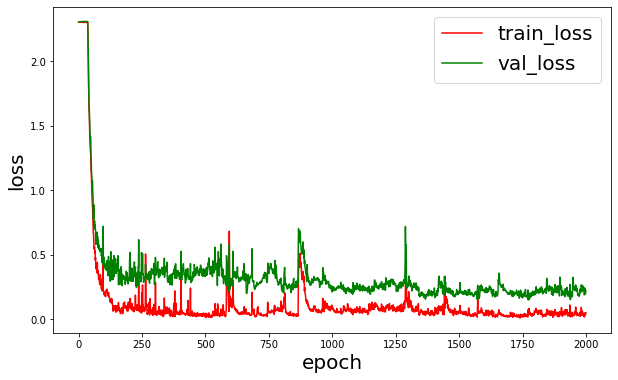

In [8]:
# plot cost curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(train_loss_his)) , np.array(train_loss_his) , c = 'r' , label = 'train_loss')
ax.plot(np.arange(len(val_loss_his)) , np.array(val_loss_his) , c = 'g' , label = 'val_loss')
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('loss' , fontsize = 20)
ax.legend(fontsize = 20)

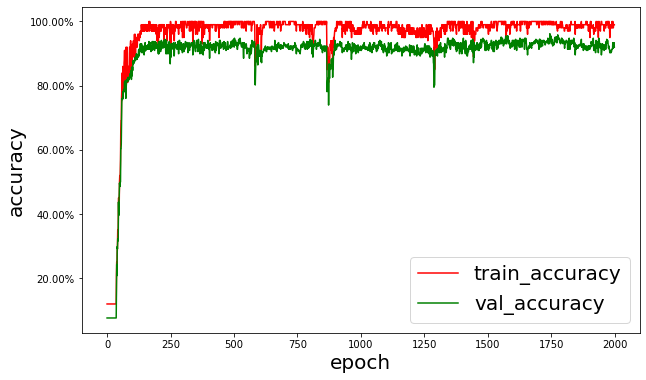

In [9]:
# plot accuracy curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(train_acc_his)) , np.array(train_acc_his) * 100 , c = 'r' , label = 'train_accuracy')
ax.plot(np.arange(len(val_acc_his)) , np.array(val_acc_his) * 100 , c = 'g' , label = 'val_accuracy')
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('accuracy' , fontsize = 20)
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.legend(fontsize = 20)